Загрузка логов из: /mnt/d/Study/python/TradingAgentClassicRL/training_data/logs
Загружено 3 логов экспериментов.

Финальные результаты (среднее за последние 100 эпизодов)


,Reward (Avg),Balance $ (Avg),Win Rate % (Avg),Trades (Avg),Max DD (Avg)
agent,,,,,
QLearning (Base),530.11,993.25,44.96,150.73,0.05
SARSA (Base),462.68,972.14,46.76,174.25,0.06
Monte (Base),265.15,1024.17,50.92,97.35,0.06


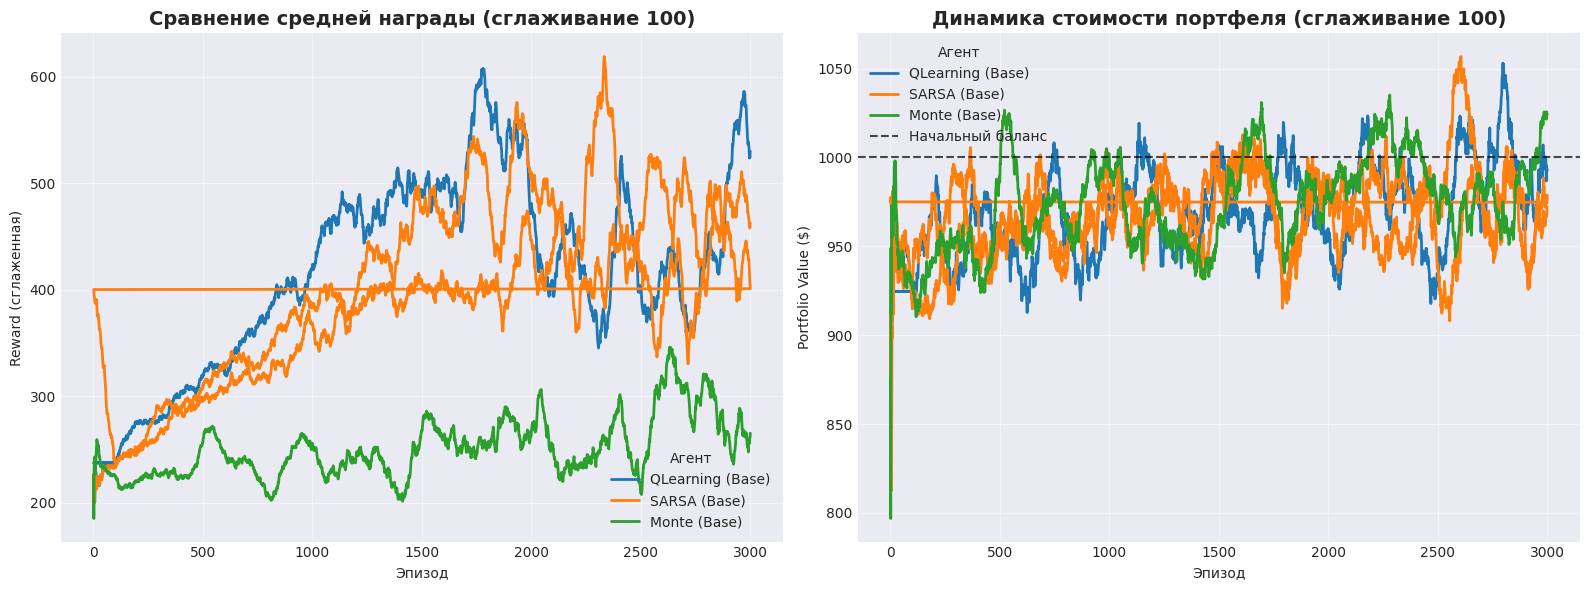

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from pathlib import Path
import os
import sys


project_root = os.path.abspath("..")
sys.path.append(project_root)

WINDOW_SIZE = 100 
TRAIN_VERSION = "v2"


agent_types = ["QLearning", "SARSA", "SARSA_Lambda", "Monte_Carlo"]
experiment_names = []

for agent in agent_types:
    experiment_names.append(f"exp_{agent.lower()}_{TRAIN_VERSION}")
    experiment_names.append(f"exp_{agent.lower()}_{TRAIN_VERSION}_finetune")


all_data = []
base_log_dir = Path(project_root) / "training_data" / "logs"
print(f"Загрузка логов из: {base_log_dir}")

for exp_name in experiment_names:
    exp_dir = base_log_dir / exp_name
    
    if not exp_dir.exists():
        continue
    
    try:
        episodes_df = pd.read_csv(exp_dir / "episodes.csv")
        
        with open(exp_dir / "training_summary.json") as f:
            summary = json.load(f)
            
        agent_raw_name = summary["config"]["agent_name"]
        
        if "finetune" in exp_name:
            agent_label = f"{agent_raw_name.split('_')[0]} (FT)"
        else:
            agent_label = f"{agent_raw_name.split('_')[0]} (Base)"
            
        episodes_df["agent"] = agent_label
        all_data.append(episodes_df)
        
    except Exception as e:
        print(f"Ошибка при загрузке логов {exp_name}: {e}")

if not all_data:
    print("\nНе удалось загрузить данные ни одного эксперимента. Проверьте пути и TRAIN_VERSION.")
    
df = pd.concat(all_data, ignore_index=True)
print(f"Загружено {len(df['agent'].unique())} логов экспериментов.")


final_metrics = (
    df.groupby("agent")
    .tail(WINDOW_SIZE)
    .groupby("agent")
    [["reward", "portfolio_value", "win_rate", "n_trades", "max_drawdown"]]
    .mean()
)

final_metrics.columns = [
    "Reward (Avg)", 
    "Balance $ (Avg)", 
    "Win Rate % (Avg)", 
    "Trades (Avg)", 
    "Max DD (Avg)"
]


final_metrics = final_metrics.sort_values("Reward (Avg)", ascending=False)

print(f"\n=======================================================")
print(f"Финальные результаты (среднее за последние {WINDOW_SIZE} эпизодов)")

display(final_metrics.round(2))
print(f"=======================================================")


plt.style.use('seaborn-v0_8-darkgrid')
agents = df["agent"].unique()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax1 = axes[0]
for agent in agents:
    agent_data = df[df["agent"] == agent]
    smoothed = agent_data["reward"].rolling(window=WINDOW_SIZE, min_periods=1).mean()
    ax1.plot(agent_data["episode"], smoothed, label=agent, linewidth=2)

ax1.set_title(f"Сравнение средней награды (сглаживание {WINDOW_SIZE})", fontsize=14, fontweight='bold')
ax1.set_xlabel("Эпизод")
ax1.set_ylabel("Reward (сглаженная)")
ax1.legend(title="Агент", loc='lower right')
ax1.grid(True, alpha=0.5)

ax2 = axes[1]
for agent in agents:
    agent_data = df[df["agent"] == agent]
    smoothed_balance = agent_data["portfolio_value"].rolling(window=WINDOW_SIZE, min_periods=1).mean()
    ax2.plot(agent_data["episode"], smoothed_balance, label=agent, linewidth=2)

INITIAL_BALANCE = 1000.0
ax2.axhline(y=INITIAL_BALANCE, color='black', linestyle='--', alpha=0.7, label='Начальный баланс')

ax2.set_title(f"Динамика стоимости портфеля (сглаживание {WINDOW_SIZE})", fontsize=14, fontweight='bold')
ax2.set_xlabel("Эпизод")
ax2.set_ylabel("Portfolio Value ($)")
ax2.legend(title="Агент", loc='upper left')
ax2.grid(True, alpha=0.5)

plt.tight_layout()
plt.show()